In [316]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.fftpack import fft, fftshift, ifft
import seaborn as sns
from collections import Counter
import pandas as pd

### Check npy

In [225]:
sinogram_path = "Data/sinogram.npy"

In [226]:
sinogram = np.load(sinogram_path)
sinogram.shape

(512, 180)

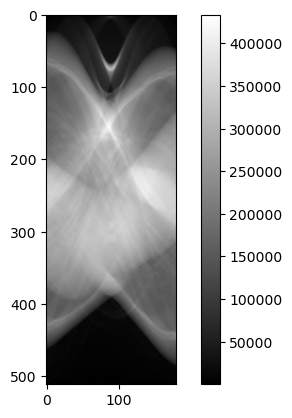

In [227]:
plt.imshow(sinogram, cmap='gray')
plt.colorbar()
plt.show()

### Setting Image Parameters

In [228]:
# 512px * 512px
nx = 512
ny = 512

# 2mm pixel
dx = 2

- need to know reason

In [229]:
x_T = (np.arange(1, nx+1)-(nx+1)/2)*dx
x = x_T.reshape(nx, 1)

In [230]:
y_T = (np.arange(1, ny+1)-(ny + 1) / 2) * -dx
y = y_T.reshape(ny, 1)

In [231]:
xx = np.repeat(x, ny, axis=1)
yy = np.repeat(y, nx, axis=1).T


- number of radial samples 
- number of ray spacing
- number of angular samples

In [232]:
nr = 180
dr = 1   
na = nr*2

- radial sample positions

In [233]:
r = dr * (np.arange(1, nr+1).T-(nr+1)/2)

- angular sample positions

In [234]:
angle = np.arange(0, na).T/na * np.pi

### Compute 0th moment
- as a function of the projection angle

In [235]:
projection = np.zeros(nr)
projection.shape

(180,)

In [236]:
for i in range(nr):
    projection_i = sinogram[:, i]
    projection[i] = sum(projection_i)

### Back projection

In [252]:
final_data = np.zeros([nx, ny])

In [253]:
test = np.ones((1,3))
result = np.tile(test, (3,1))
result[:,1]

array([1., 1., 1.])

In [254]:
for i in range(nr):
    projection_i = np.reshape(sinogram[:, i], (1,512))
    print(f"angle {i} of {nr}: ")
    projection_smear = np.tile(projection_i, (512,1))
    rot = rotate(projection_smear, i, reshape=False)
    final_data += rot

angle 0 of 180: 
angle 1 of 180: 
angle 2 of 180: 
angle 3 of 180: 
angle 4 of 180: 
angle 5 of 180: 
angle 6 of 180: 
angle 7 of 180: 
angle 8 of 180: 
angle 9 of 180: 
angle 10 of 180: 
angle 11 of 180: 
angle 12 of 180: 
angle 13 of 180: 
angle 14 of 180: 
angle 15 of 180: 
angle 16 of 180: 
angle 17 of 180: 
angle 18 of 180: 
angle 19 of 180: 
angle 20 of 180: 
angle 21 of 180: 
angle 22 of 180: 
angle 23 of 180: 
angle 24 of 180: 
angle 25 of 180: 
angle 26 of 180: 
angle 27 of 180: 
angle 28 of 180: 
angle 29 of 180: 
angle 30 of 180: 
angle 31 of 180: 
angle 32 of 180: 
angle 33 of 180: 
angle 34 of 180: 
angle 35 of 180: 
angle 36 of 180: 
angle 37 of 180: 
angle 38 of 180: 
angle 39 of 180: 
angle 40 of 180: 
angle 41 of 180: 
angle 42 of 180: 
angle 43 of 180: 
angle 44 of 180: 
angle 45 of 180: 
angle 46 of 180: 
angle 47 of 180: 
angle 48 of 180: 
angle 49 of 180: 
angle 50 of 180: 
angle 51 of 180: 
angle 52 of 180: 
angle 53 of 180: 
angle 54 of 180: 
angle 55 of 180: 
an

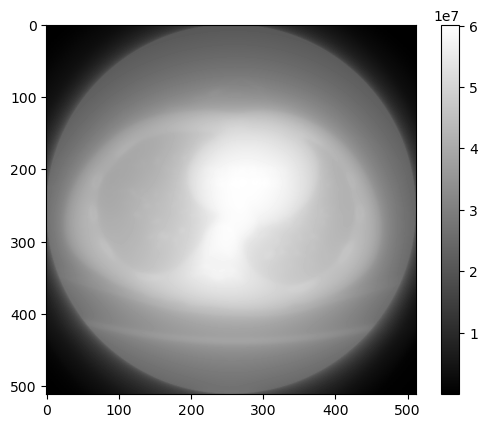

In [255]:
plt.imshow(final_data, cmap='gray')
plt.colorbar()
plt.show()

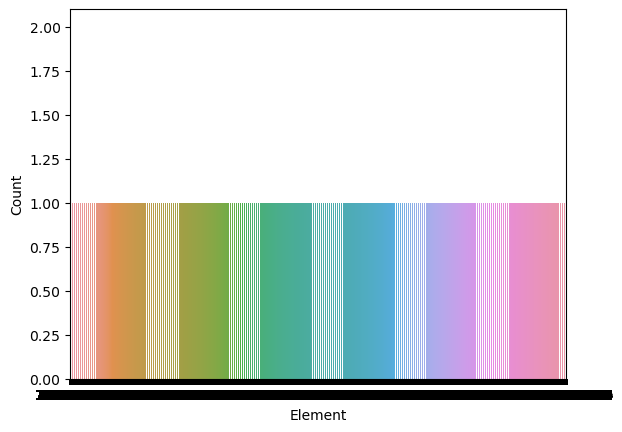

In [241]:
# Create a count plot
data_cut = np.round(final_data, 2).flatten()
data_cut = Counter(data_cut)

df = pd.DataFrame.from_dict(data_cut, orient='index').reset_index()
df.columns = ['Element', 'Count']
sns.barplot(x='Element', y='Count', data=df)

plt.show()

In [261]:
print(final_data.max(), final_data.min())

60143533.1587036 1438.162196361637


In [280]:
final_data_c = np.clip(final_data, a_min=30000000, a_max=None)
print(final_data_c.max(), final_data_c.min())


60143533.1587036 30000000.0


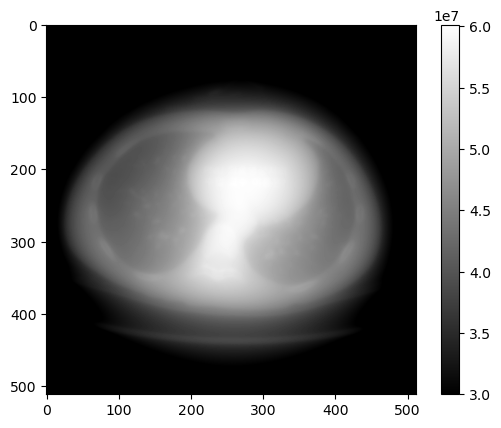

In [281]:
plt.imshow(final_data_c, cmap='gray')
plt.colorbar()
plt.show()

In [300]:
final_data_c2 = np.clip(final_data, a_min=55000000, a_max=60000000)
print(final_data_c2.max(), final_data_c2.min())

60000000.0 55000000.0


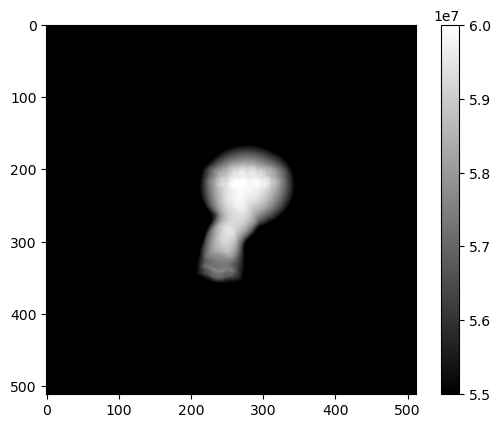

In [301]:
plt.imshow(final_data_c2, cmap='gray')
plt.colorbar()
plt.show()

- 숨은 question: PNU 의료영상처리 수업 교수 이름은?: 김민우 교수님

### FBP algorithm
- fft, fftshift to center low frequecy

In [244]:
sinogram_fft = np.fft.fft(sinogram)
sinogram_fft_shifted = np.fft.fftshift(sinogram_fft, axes=0)
print(sinogram_fft_shifted.shape)

(512, 180)


- making LAM-Lock
    - slope -1 till 128 and then +1 till 256

In [245]:
a = len(sinogram)
# freqs = np.linspace(-0.5, 0.5, a)
freqs = np.reshape(np.linspace(1, -1, a), (a, 1))
print(freqs.shape)

(512, 1)


In [246]:
ram_lak_filter = abs(freqs)
ram_lak_filter = np.tile(ram_lak_filter, (1, 180))
print(ram_lak_filter.shape)

(512, 180)


In [247]:
sinogramfilt = np.abs(np.fft.ifft(np.fft.ifftshift(sinogram_fft_shifted * ram_lak_filter)))

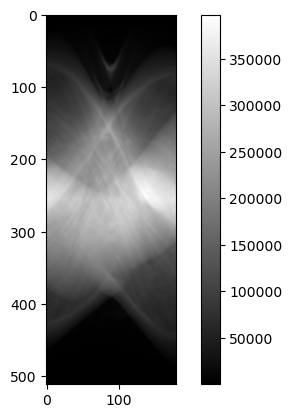

In [248]:
plt.imshow(sinogramfilt, cmap='gray')
plt.colorbar()
plt.show()

In [249]:
final_filtered_data = np.zeros([nx, ny])

In [250]:
for i in range(nr):
    print(f"angle {i} of {nr}: ")
    f_projection_i = np.reshape(sinogramfilt[:, i], (1,512))
    f_projection_smear = np.tile(f_projection_i, (512,1))
    f_rot = rotate(f_projection_smear, i, reshape=False)
    final_filtered_data += f_rot

angle 0 of 180: 
angle 1 of 180: 
angle 2 of 180: 
angle 3 of 180: 
angle 4 of 180: 
angle 5 of 180: 
angle 6 of 180: 
angle 7 of 180: 
angle 8 of 180: 
angle 9 of 180: 
angle 10 of 180: 
angle 11 of 180: 
angle 12 of 180: 
angle 13 of 180: 
angle 14 of 180: 
angle 15 of 180: 
angle 16 of 180: 
angle 17 of 180: 
angle 18 of 180: 
angle 19 of 180: 
angle 20 of 180: 
angle 21 of 180: 
angle 22 of 180: 
angle 23 of 180: 
angle 24 of 180: 
angle 25 of 180: 
angle 26 of 180: 
angle 27 of 180: 
angle 28 of 180: 
angle 29 of 180: 
angle 30 of 180: 
angle 31 of 180: 
angle 32 of 180: 
angle 33 of 180: 
angle 34 of 180: 
angle 35 of 180: 
angle 36 of 180: 
angle 37 of 180: 
angle 38 of 180: 
angle 39 of 180: 
angle 40 of 180: 
angle 41 of 180: 
angle 42 of 180: 
angle 43 of 180: 
angle 44 of 180: 
angle 45 of 180: 
angle 46 of 180: 
angle 47 of 180: 
angle 48 of 180: 
angle 49 of 180: 
angle 50 of 180: 
angle 51 of 180: 
angle 52 of 180: 
angle 53 of 180: 
angle 54 of 180: 
angle 55 of 180: 
an

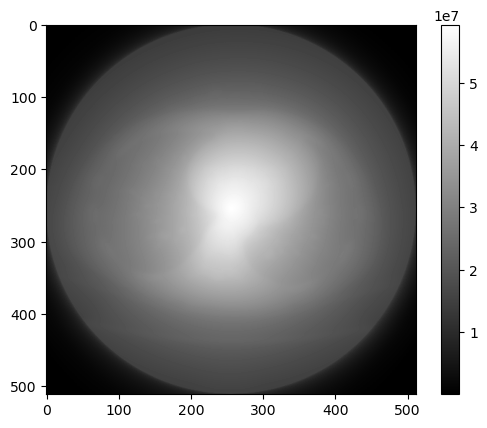

In [251]:
plt.imshow(final_filtered_data, cmap='gray')
plt.colorbar()
plt.show()

In [302]:
print(final_filtered_data.max(), final_filtered_data.min())

59337950.13019764 2.8144074292790635


In [309]:
final_filtered_data_c = np.clip(final_filtered_data, a_min=18000000, a_max=None)
print(final_filtered_data_c.max(), final_filtered_data_c.min())

59337950.13019764 18000000.0


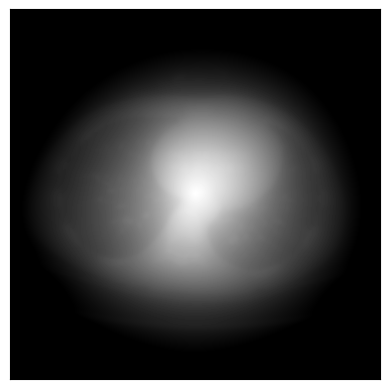

In [313]:
plt.imshow(final_filtered_data_c, cmap='gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  
plt.show(block=False)
plt.show()

- testing another ram-lack filter

a = len(sinogram)
# freqs = np.linspace(-0.5, 0.5, a)
freqs = np.reshape(np.linspace(1, -1, a), (a, 1))
print(freqs.shape)

- making ram-lak filter in the frequency domain

In [317]:
def ram_lak_filter(n):
    filt = np.zeros(n)
    
    inc = (2*np.pi)/(n-n%2)
    offset  = 0
    for i in range(n):
        if n%2 ==0 and i == n/2:
            offset = 1
        filt[i] = abs(-1*np.pi + inc *(i+offset))
        
    return filt

In [318]:
FT_q = fftshift(ram_lak_filter(len(sinogram[0])))

In [321]:
conv_store = []
for i in range(len(sinogram)):

    p = sinogram[i]
    FT_p = fft(p)
    conv_store.append(np.real(ifft(FT_p * FT_q)))

In [323]:
conv_store = np.array(conv_store)
print(conv_store.shape)

(512, 180)


In [324]:
ram_lak_data = np.zeros([nx, ny])

In [325]:
for i in range(nr):
    print(f"angle {i} of {nr}: ")
    f_projection_i = np.reshape(conv_store[:, i], (1,512))
    f_projection_smear = np.tile(f_projection_i, (512,1))
    f_rot = rotate(f_projection_smear, i, reshape=False)
    ram_lak_data += f_rot

angle 0 of 180: 
angle 1 of 180: 
angle 2 of 180: 
angle 3 of 180: 
angle 4 of 180: 
angle 5 of 180: 
angle 6 of 180: 
angle 7 of 180: 
angle 8 of 180: 
angle 9 of 180: 
angle 10 of 180: 
angle 11 of 180: 
angle 12 of 180: 
angle 13 of 180: 
angle 14 of 180: 
angle 15 of 180: 
angle 16 of 180: 
angle 17 of 180: 
angle 18 of 180: 
angle 19 of 180: 
angle 20 of 180: 
angle 21 of 180: 
angle 22 of 180: 
angle 23 of 180: 
angle 24 of 180: 
angle 25 of 180: 
angle 26 of 180: 
angle 27 of 180: 
angle 28 of 180: 
angle 29 of 180: 
angle 30 of 180: 
angle 31 of 180: 
angle 32 of 180: 
angle 33 of 180: 
angle 34 of 180: 
angle 35 of 180: 
angle 36 of 180: 
angle 37 of 180: 
angle 38 of 180: 
angle 39 of 180: 
angle 40 of 180: 
angle 41 of 180: 
angle 42 of 180: 
angle 43 of 180: 
angle 44 of 180: 
angle 45 of 180: 
angle 46 of 180: 
angle 47 of 180: 
angle 48 of 180: 
angle 49 of 180: 
angle 50 of 180: 
angle 51 of 180: 
angle 52 of 180: 
angle 53 of 180: 
angle 54 of 180: 
angle 55 of 180: 
an

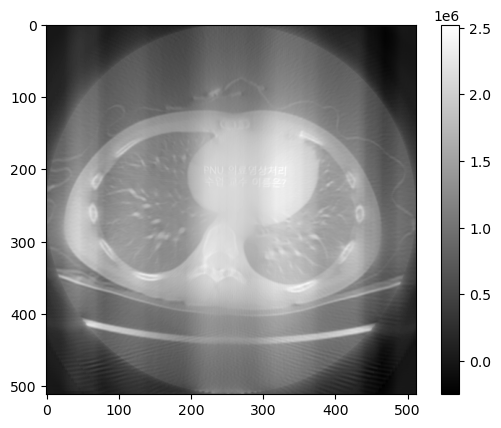

In [327]:
plt.imshow(ram_lak_data, cmap='gray')
plt.colorbar()
plt.show()